In [64]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import yaml

from scipy.stats import poisson, betabinom, nbinom, norm, planck, truncnorm
from scipy.optimize import minimize

In [2]:
with open("configfile.yaml", 'r') as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

#sessions = config['sessions']
sessions = ['i140703-001','l101210-001']

#epochs = config['epochs']
epochs = ['start', 'cue1', 'earlydelay', 'latedelay', 'movement', 'hold']

#trialtypes = config['trialtypes']
trialtypes = ['PGHF', 'PGLF' ,'SGHF', 'SGLF' ]

winlen = config['winlen']
unit = config['unit']
binsize = (config['binsize'] * pq.s).rescale(unit)
firing_rate_threshold = config['firing_rate_threshold']
seed = config['seed']
processes = config['processes']
SNR_thresh = 2.5
synchsize = 2
sep = 2 * winlen * binsize
max_refractory = 4 * pq.ms
load_original_data = False

trial_length = 0.5 * pq.s

sampling_frequency = 30*pq.kHz
samples_per_spikes = {'i140703-001': 38, 'l101210-001': 48}
spike_width = {session: (samples_per_spikes[session]/sampling_frequency).simplified
               for session in sessions}
n_bins = {session: np.ceil((trial_length/spike_width[session]).item()).astype(int)
               for session in sessions}

In [3]:
# for session in sessions:
#     for epoch in epochs:
#         for trialtype in trialtypes:
session = 'i140703-001'
epoch = 'start'
trialtype = 'PGHF'
sts = np.load(f'../data/concatenated_spiketrains/'
              f'{session}/'
              f'{epoch}_{trialtype}.npy',
              allow_pickle=True)


In [4]:
n_trials = int(sts[0].t_stop/(trial_length+sep))
n_spiketrains = len(sts)

In [5]:
spike_counts = np.zeros((n_spiketrains, n_trials), dtype=int)
for st_id, spiketrain in enumerate(sts):
    for trial in range(n_trials):
        spike_counts[st_id, trial] = sum(np.all((trial*(trial_length+sep) < spiketrain,
                                  spiketrain < (trial+1)*(trial_length+sep)), axis=0))

In [6]:
highest_count = np.max(spike_counts)

In [7]:
highest_count

35

/home/bouss/Documents/Explainable-AI/envs/surrogates/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/home/bouss/Documents/Explainable-AI/envs/surrogates/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/home/bouss/Documents/Explainable-AI/envs/surrogates/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/home/bouss/Documents/Explainable-AI/envs/surrogates/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))
/home/bouss/Documents/Explainable-AI/envs/surrogates/lib/python3.8/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scala

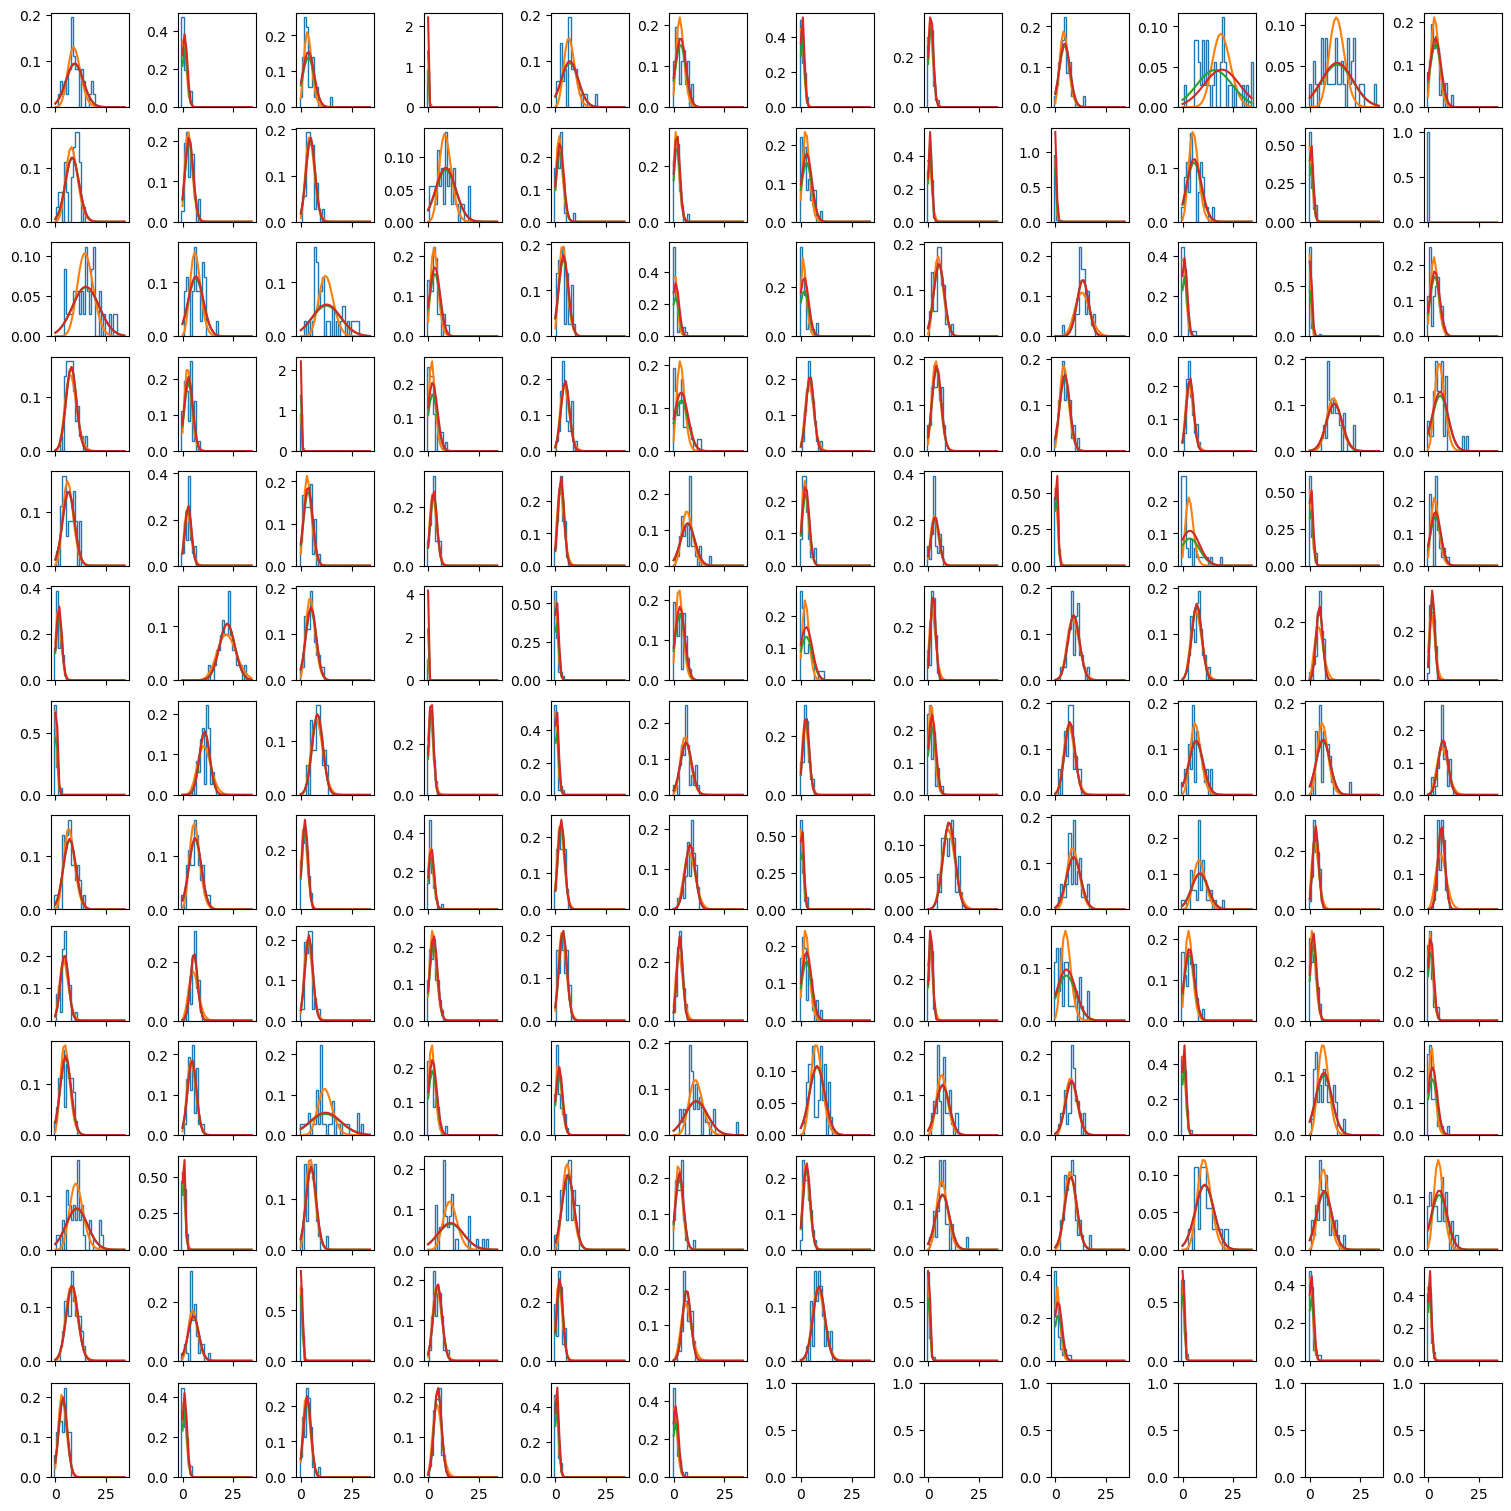

In [70]:
# Full image
n_plots = len(sts)
# Less plots for easier exploration
# n_plots = 4*4
fig, axes = plt.subplots(int(np.ceil(np.sqrt(n_plots))),
                         int(np.floor(np.sqrt(n_plots))), figsize=(15, 15), 
                        sharex='all',
                         #sharey='all',
                         constrained_layout=True)
for st_id, (spiketrain, ax) in enumerate(zip(sts, axes.flatten())):
    counts, bins = np.histogram(spike_counts[st_id], bins=np.arange(highest_count+1), density=True)
    
    # shifting by 0.5 to have better graphical overlap 
    ax.stairs(counts, bins-0.5)
    
    masked_counts = counts[counts>0]
    masked_arange = np.arange(len(counts))[counts>0]
    
    def loglikelihood_poisson(params):
        return np.sum(masked_counts * poisson.logpmf(masked_arange, mu=params[0]))
    poisson_res = minimize(loglikelihood_poisson, x0=(np.mean(spike_counts[st_id]), ))
    
    ax.plot(np.arange(len(counts)), poisson.pmf(k=np.arange(len(counts)), mu=poisson_res.x[0]))
    
    # Fitting a Gaussian distribution is not valid. As the data is defined only a semi-positive integers.
    # It can be clearly seen that the distribution is cut off.
    ax.plot(np.arange(len(counts)), norm.pdf(x=np.arange(len(counts)),
                                             loc=np.mean(spike_counts[st_id]),
                                             scale=np.std(spike_counts[st_id], ddof=1)))
    
    def loglikelihood_truncnorm(params):
        return np.sum(masked_counts * truncnorm.logpdf(masked_arange, a=-params[0]/params[1], b=np.inf, loc=params[0], scale=params[1]))
    truncnorm_res = minimize(loglikelihood_poisson, x0=(np.mean(spike_counts[st_id]), np.std(spike_counts[st_id], ddof=1)))
    
    ax.plot(np.arange(len(counts)), truncnorm.pdf(np.arange(len(counts)), a=-truncnorm_res.x[0]/truncnorm_res.x[1],
                                                  b=np.inf, loc=truncnorm_res.x[0], scale=truncnorm_res.x[1]))